In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [2]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.2. Data Processing/Output'
cur_date = '020226'

library(missForest)
library(readxl)
library(openxlsx)
library(tidyverse)
library(factoextra)
library(ggh4x)

# reading in files
ws_df = data.frame(Sample = 'WS', read_excel("Input/Woodsmoke_Data_012226.xlsx", sheet = 2)) %>%
    select(-Number)
wf_df = data.frame(Sample = 'WF', read_excel("Input/Wildfire_Data_012226.xlsx", sheet = 2)) %>%
    select(-Number)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [3]:
head(ws_df)
head(wf_df)

,Sample,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,DTXSID,Name,Value
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WS,429174,Arif et al. 2017,1,429174_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
2,WS,429174,Arif et al. 2017,2,429174_2,PAH,Weight,DTXSID3023845,Acenaphthylene,13.42
3,WS,298566,Jalava et al. 2010,1,298566_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
4,WS,298566,Jalava et al. 2010,2,298566_2,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
5,WS,298566,Jalava et al. 2010,3,298566_3,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
6,WS,298566,Jalava et al. 2010,4,298566_4,PAH,Weight,DTXSID3023845,Acenaphthylene,NA


,Sample,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,DTXSID,Name,Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WF,1289737,Campbell et al. 2024,1,1289737_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
2,WF,1289739,Campos et al. 2019,1,1289739_1,PAH,Weight,DTXSID3023845,Acenaphthylene,3.5200000000000002E-2
3,WF,1289739,Campos et al. 2019,2,1289739_2,PAH,Weight,DTXSID3023845,Acenaphthylene,1.21E-2
4,WF,1289739,Campos et al. 2019,3,1289739_3,PAH,Weight,DTXSID3023845,Acenaphthylene,8.8000000000000005E-3
5,WF,1289739,Campos et al. 2019,4,1289739_4,PAH,Weight,DTXSID3023845,Acenaphthylene,1.12E-2
6,WF,1289739,Campos et al. 2019,5,1289739_5,PAH,Weight,DTXSID3023845,Acenaphthylene,4.5199999999999997E-2


In [4]:
dim(ws_df)
dim(wf_df)

[1] 1407   10

[1] 2423   10

Starting with 4391 WS records and 3795 WF records. 

In [5]:
# combining dfs
combined_df = rbind(ws_df, wf_df)
           
head(combined_df)

,Sample,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,DTXSID,Name,Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WS,429174,Arif et al. 2017,1,429174_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
2,WS,429174,Arif et al. 2017,2,429174_2,PAH,Weight,DTXSID3023845,Acenaphthylene,13.42
3,WS,298566,Jalava et al. 2010,1,298566_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
4,WS,298566,Jalava et al. 2010,2,298566_2,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
5,WS,298566,Jalava et al. 2010,3,298566_3,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
6,WS,298566,Jalava et al. 2010,4,298566_4,PAH,Weight,DTXSID3023845,Acenaphthylene,NA


In [6]:
length(unique(combined_df$Name))
length(unique(ws_df$Name))
length(unique(wf_df$Name))

[1] 33

[1] 32

[1] 32

114 unique metals/chemicals total.

# Filter #1: Chemical/Metal Background Filters

Determining what variables have missing data for all variables delineated based on the dfs the data will be split into and analyzed. 

A variable (ie. `Name` which represents a chemical or metal) will be retained if >= 20% of its experimental data points were measurable values. In other words, chemicals or metals were excluded if they had NAs (not evaluated) or had non-detect values across >= 80% of the samples.

In [7]:
`%notin%` <- Negate(`%in%`)

sample_type_presence_df = combined_df %>%
    # if an experimental value is there count it as being "present"
    mutate(count = ifelse(Value %notin% c('NA', 'ND'), 1, 0)) %>%
    # determining which have at least 20% experimental values for each chemical/metal
    group_by(Metric, Sample, Name) %>%
    # calculating the percentage of experimental data points
    reframe(Variable_Presence_Percentage = (sum(count)/n()) * 100) %>%
    filter(Variable_Presence_Percentage >= 25) 

head(sample_type_presence_df)

Metric,Sample,Name,Variable_Presence_Percentage
<chr>,<chr>,<chr>,<dbl>
Volume,WF,Acenaphthylene,27.02703
Volume,WF,Anthracene,40.54054
Volume,WF,Benz(a)anthracene,62.16216
Volume,WF,Benzene,100.00000
Volume,WF,Benzo(GHI)perylene,56.75676
Volume,WF,Benzo(a)pyrene,48.64865


In [8]:
# filtering the original df
filter1_df = inner_join(sample_type_presence_df[,1:3], combined_df) 

head(filter1_df)

Joining with `by = join_by(Metric, Sample, Name)`


Metric,Sample,Name,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Volume,WF,Acenaphthylene,1289895,Silberstein et al. 2023,1,1289895_1,PAH,DTXSID3023845,7.0000000000000007E-2
Volume,WF,Acenaphthylene,1286055,Simms et al. 2021,1,1286055_1,PAH,DTXSID3023845,NA
Volume,WF,Acenaphthylene,1285830,Navarro et al. 2019,1,1285830_1,PAH,DTXSID3023845,1
Volume,WF,Acenaphthylene,1285830,Navarro et al. 2019,2,1285830_2,PAH,DTXSID3023845,1
Volume,WF,Acenaphthylene,1285830,Navarro et al. 2019,3,1285830_3,PAH,DTXSID3023845,1
Volume,WF,Acenaphthylene,1289909,Trieu et al. 2024,1,1289909_1,PAH,DTXSID3023845,3.8999999999999998E-3


In [9]:
dim(combined_df)
dim(filter1_df)

combined_df %>%
    group_by(Sample) %>%
    count()
filter1_df %>%
    group_by(Sample) %>%
    count()

[1] 3830   10

[1] 3756   10

Sample,n
<chr>,<int>
WF,2423
WS,1407


Sample,n
<chr>,<int>
WF,2349
WS,1407


Started with 8186 records, 1638 were removed, leaving 6548. 

# Filter #2: Study Background Filter

A study will be retained if >= 20% of its experimental data points were measurable values. In other words, chemicals were excluded if they were NAs (not evaluated) or had non-detect values across < 20% of the samples.

In [10]:
study_type_presence_df = filter1_df %>%
    # if an experimental value is there count it as being "present"
    mutate(count = ifelse(Value %notin% c('NA', 'ND'), 1, 0)) %>%
    # determining which have at least 20% experimental values for each chemical/metal
    group_by(Metric, Class, HAWC_ID) %>%
    # calculating the percentage of experimental data points
    reframe(Study_Presence_Percentage = (sum(count)/n()) * 100) %>%
    filter(Study_Presence_Percentage >= 25) 

head(study_type_presence_df)

Metric,Class,HAWC_ID,Study_Presence_Percentage
<chr>,<chr>,<chr>,<dbl>
Volume,Metal,1070627,88.88889
Volume,Metal,1263480,85.18519
Volume,Metal,1263484,66.66667
Volume,Metal,1289778,55.55556
Volume,Metal,1289808,100.00000
Volume,Metal,1289847,88.88889


In [11]:
filter2_df = inner_join(study_type_presence_df[,1:3], filter1_df)

head(filter2_df)

Joining with `by = join_by(Metric, Class, HAWC_ID)`


Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,Study_Sample_ID,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
Volume,Metal,1070627,WF,Calcium,Siregar et al. 2022,1,1070627_1,Ca,1370.1
Volume,Metal,1070627,WF,Calcium,Siregar et al. 2022,2,1070627_2,Ca,595.20000000000005
Volume,Metal,1070627,WF,Copper,Siregar et al. 2022,1,1070627_1,Cu,127
Volume,Metal,1070627,WF,Copper,Siregar et al. 2022,2,1070627_2,Cu,20.3
Volume,Metal,1070627,WF,Iron,Siregar et al. 2022,1,1070627_1,Fe,1115
Volume,Metal,1070627,WF,Iron,Siregar et al. 2022,2,1070627_2,Fe,427


In [12]:
dim(filter1_df)
dim(filter2_df)

[1] 3756   10

[1] 3535   10

122 more records were removed.

# Filter #3: Chemical/Metal Background Filter

In the intial filter, WS and WF samples were combined. However, this time variables (ie. metal or chemical) will be split based on their `Metric` (ie. volume or weight) and then retained if that variable is found in both woodsmoke and wildfire samples within volume or weight samples.

In [13]:
split_filtered_df = filter2_df %>%
    group_by(Sample, Metric) %>%
    group_split

split_ws_vol_df = split_filtered_df[[3]]
split_ws_weight_df = split_filtered_df[[4]]
split_wf_vol_df = split_filtered_df[[1]]
split_wf_weight_df = split_filtered_df[[2]]

In [14]:
# seeing how many unique variables are in each df and if they're consistent in each file
length(unique(split_ws_vol_df$Name))
length(unique(split_wf_vol_df$Name))
length(unique(split_ws_weight_df$Name))
length(unique(split_wf_weight_df$Name))

[1] 28

[1] 26

[1] 27

[1] 27

In [15]:
# they're not so first getting variables that are in weight or volume samples
consistent_wf_vol_df = split_wf_vol_df %>%
    filter(Name %in% unique(split_ws_vol_df$Name))
consistent_ws_vol_df = split_ws_vol_df %>%
    filter(Name %in% consistent_wf_vol_df$Name)
consistent_wf_weight_df = split_wf_weight_df %>%
    filter(Name %in% unique(split_ws_weight_df$Name))
consistent_ws_weight_df = split_ws_weight_df %>%
    filter(Name %in% consistent_wf_weight_df$Name)

length(unique(consistent_wf_vol_df$Name))
length(unique(consistent_ws_vol_df$Name))
length(unique(consistent_wf_weight_df$Name))
length(unique(consistent_ws_weight_df$Name))

[1] 25

[1] 25

[1] 26

[1] 26

There were 77, 57, 51 and 89 woodsmoke weight, woodsmoke volume, wildfire weight, and wildfire volume samples, respectively. 37 variables were common between volume samples and 37 were common between weight records and will be retained.

In [16]:
# recombining data
vol_df = rbind(consistent_ws_vol_df, consistent_wf_vol_df)
weight_df = rbind(consistent_ws_weight_df, consistent_wf_weight_df)

head(vol_df)

Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,Study_Sample_ID,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
Volume,Metal,1263480,WS,Calcium,Burnet et al. 1990,1,1263480_1,Ca,486500
Volume,Metal,1263480,WS,Calcium,Burnet et al. 1990,2,1263480_2,Ca,424250
Volume,Metal,1263480,WS,Calcium,Burnet et al. 1990,3,1263480_3,Ca,212000
Volume,Metal,1263480,WS,Copper,Burnet et al. 1990,1,1263480_1,Cu,12000
Volume,Metal,1263480,WS,Copper,Burnet et al. 1990,2,1263480_2,Cu,10375
Volume,Metal,1263480,WS,Copper,Burnet et al. 1990,3,1263480_3,Cu,NA


# Square Root Imputation

Taking the square root of the min value to impute MNAR data.

In [17]:
# first determining number of ND and NA values in each df
vol_df %>%
    filter(Value %in% c('NA', 'ND')| grepl("<", Value)) %>%
    group_by(Value) %>%
    summarize(n())

weight_df %>%
    filter(Value %in% c('NA', 'ND')| grepl("<", Value)) %>%
    group_by(Value) %>%
    summarize(n())

Value,n()
<chr>,<int>
<0.0456,1
NA,240
ND,34


Value,n()
<chr>,<int>
<0.0005,6
<0.0006,2
<0.0007,3
<0.04,1
NA,723
ND,82


In [18]:
dim(vol_df)
dim(weight_df)

[1] 1057   10

[1] 2356   10

In [19]:
# creating a df for MAR data
mar_weight_df = weight_df %>%
    filter(Value == 'NA')
mar_vol_df = vol_df %>%
    filter(Value == 'NA')

# creating dfs for studies that contain MNAR data
preimputed_lod_weight_df = anti_join(weight_df, mar_weight_df) 
preimputed_lod_vol_df = anti_join(vol_df, mar_vol_df) 

Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID, DTXSID, Value)`
Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID, DTXSID, Value)`


In [20]:
# first imputing non detect values for studies that had a limit of detection (LOD) provided
lod_values_vol_df = preimputed_lod_vol_df %>%
    filter(grepl("<", Value)) %>%
    separate(Value, sep = '<', into = c(NA, 'Value')) %>%
    mutate(Value = sqrt(as.numeric(Value)))
lod_values_weight_df = preimputed_lod_weight_df %>%
    filter(grepl("<", Value)) %>%
    separate(Value, sep = '<', into = c(NA, 'Value')) %>%
    mutate(Value = sqrt(as.numeric(Value)))

dim(lod_values_vol_df)
dim(lod_values_weight_df)
head(lod_values_vol_df)

# adding these newly imputed values back into the df
preimputed_vol_df = rbind(anti_join(preimputed_lod_vol_df, lod_values_vol_df[,1:8]), lod_values_vol_df)
preimputed_weight_df = rbind(anti_join(preimputed_lod_weight_df, lod_values_weight_df[,1:8]), lod_values_weight_df)

[1]  1 10

[1] 12 10

Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,Study_Sample_ID,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Volume,PAH,1289889,WF,"Dibenzo(a,h)anthracene",Scaramboni et al. 2024,2,1289889_2,DTXSID9020409,0.2135416


Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID)`
Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID)`


In [21]:
preimputed_weight_df$Value = as.numeric(preimputed_weight_df$Value)
preimputed_vol_df$Value = as.numeric(preimputed_vol_df$Value)
mar_weight_df$Value = as.numeric(mar_weight_df$Value)
mar_vol_df$Value = as.numeric(mar_vol_df$Value)

# reordering cols
preimputed_weight_df = preimputed_weight_df[,c(3,1,4,6,7,8,2,9,5,10)] %>%
    # normalizing data
    mutate(Value = log2(Value + 1))
preimputed_vol_df = preimputed_vol_df[,c(3,1,4,6,7,8,2,9,5,10)] %>%
    # normalizing data
    mutate(Value = log2(Value + 1))

head(preimputed_weight_df)

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Al,Aluminum,9.627534
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Al,Aluminum,9.182394
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Ca,Calcium,11.322492
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Ca,Calcium,12.600610
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.357552
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,NA


In [22]:
# creating a df for MNAR data
mnar_weight_df = preimputed_weight_df %>%
    filter(is.na(Value))
mnar_vol_df = preimputed_vol_df %>%
    filter(is.na(Value))

head(mnar_weight_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,NA
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,NA
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Mn,Manganese,NA
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Mn,Manganese,NA
271638,Weight,WS,Jalava et al. 2012,1,271638_1,Metal,Pb,Lead,NA
271638,Weight,WS,Jalava et al. 2012,2,271638_2,Metal,Pb,Lead,NA


In [23]:
square_root_imputation = function(mnar_df, preimputed_df){
    # """
    # Imputing MNAR values based on the square root of the minimum concentration for each chemical 
    # within a study or metal.
    
    # :param: MNAR dataframe, preimputed dataframe
    # :output: a dataframe with imputed values

    # """

    id_df = mnar_df[is.na(mnar_df$Value),]
    study_ids = unique(id_df$HAWC_ID)
    
    imputed_df = data.frame()
    for (i in 1:length(id_df$HAWC_ID)){
    
        filtered_df = preimputed_df %>%
            filter(HAWC_ID == id_df$HAWC_ID[i], DTXSID == id_df$DTXSID[i])
    
        na_df = filtered_df %>%
            filter(is.na(Value)) %>%
            mutate(Value = sqrt(min(filtered_df$Value, na.rm = TRUE)))
    
        # combining rows of data
        combined_df = rbind(filtered_df %>%
            filter(!is.na(Value)), na_df)
    
        imputed_df = rbind(imputed_df, combined_df) %>%
                        unique()
    }
    return(imputed_df)    
    
}

# calling fn
imputed_vol_df = square_root_imputation(mnar_vol_df, preimputed_vol_df) %>%
    mutate(Value = ifelse(Value == Inf, NA, Value))
imputed_weight_df = square_root_imputation(mnar_weight_df, preimputed_weight_df) %>%
    mutate(Value = ifelse(Value == Inf, NA, Value))
    
head(imputed_weight_df)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; retur

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.357552
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,2.314639
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Cd,Cadmium,4.925999
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,2.219459
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Mn,Manganese,NA
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Mn,Manganese,NA


In [24]:
# there are still a few variables that didn't have any values to do the square root imputation
# their imputed values will be based off of distributions from other studies
other_studies_vol_df = semi_join(preimputed_vol_df %>%
                filter(!is.na(Value)), imputed_vol_df %>%
                               filter(is.na(Value)) %>%
    select(2,3,7,8)) %>%
    group_by(DTXSID) %>%
    summarize(Value = sqrt(min(Value)))

other_studies_weight_df = semi_join(preimputed_weight_df %>%
                filter(!is.na(Value)), imputed_weight_df %>%
                               filter(is.na(Value)) %>%
    select(2,3,7,8)) %>%
    group_by(DTXSID) %>%
    summarize(Value = sqrt(min(Value)))

head(other_studies_vol_df)
dim(other_studies_vol_df)
head(other_studies_weight_df)
dim(other_studies_weight_df)

Joining with `by = join_by(Metric, Sample, Class, DTXSID)`
Joining with `by = join_by(Metric, Sample, Class, DTXSID)`


DTXSID,Value
<chr>,<dbl>
DTXSID0022432,0.08224829
DTXSID0023878,0.06120571
DTXSID0023907,0.03501100
DTXSID2020139,0.10920141
DTXSID3024104,0.03797334
DTXSID6024254,0.05233087


[1] 8 2

DTXSID,Value
<chr>,<dbl>
DTXSID0023878,0.0480257
DTXSID0023907,0.1038260
DTXSID3023845,0.3708147
DTXSID8020913,0.3708147
Mn,0.5244111
Pb,0.9543231


[1] 6 2

7 (volume) and 14 (weight) samples were imputed based on values from other studies.

In [25]:
# removing NAs from the imputed df 
removed_imputed_vol_df = imputed_vol_df %>%
    filter(!is.na(Value))
removed_imputed_weight_df = imputed_weight_df %>%
    filter(!is.na(Value))

# adding in the newly imputed values back in 
all_imputed_vol_df = left_join(imputed_vol_df %>%
        filter(is.na(Value)) %>%
        select(-Value), other_studies_vol_df)

all_imputed_weight_df = left_join(imputed_weight_df %>%
        filter(is.na(Value)) %>%
        select(-Value), other_studies_weight_df)

all_imputed_vol_df = rbind(removed_imputed_vol_df, all_imputed_vol_df)
all_imputed_weight_df = rbind(removed_imputed_weight_df, all_imputed_weight_df)

head(all_imputed_weight_df)

Joining with `by = join_by(DTXSID)`
Joining with `by = join_by(DTXSID)`


HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.35755200
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,2.31463863
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Cd,Cadmium,4.92599942
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,2.21945926
1098462,Weight,WS,Niu et al. 2023,1,1098462_1,PAH,DTXSID0023878,Anthracene,0.02856915
1098462,Weight,WS,Niu et al. 2023,2,1098462_2,PAH,DTXSID0023878,Anthracene,0.01435529


In [26]:
# creating 1 df
mnar_imputed_vol_df = rbind(#imputed data
                               all_imputed_vol_df,
                               # adding in MAR data
                               mar_vol_df,
                               # adding back in non-imputed data
                               anti_join(preimputed_vol_df, all_imputed_vol_df[,1:8]))
mnar_imputed_weight_df = rbind(# imputed data
                               all_imputed_weight_df,
                               # adding in MAR data
                               mar_weight_df,
                               # adding back in non-imputed data
                               anti_join(preimputed_weight_df, all_imputed_weight_df[,1:8]))

head(mnar_imputed_weight_df)
dim(mnar_imputed_vol_df)
dim(mnar_imputed_weight_df)

Joining with `by = join_by(HAWC_ID, Metric, Sample, Study, Sample_Number,
Study_Sample_ID, Class, DTXSID)`
Joining with `by = join_by(HAWC_ID, Metric, Sample, Study, Sample_Number,
Study_Sample_ID, Class, DTXSID)`


HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.35755200
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,2.31463863
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Cd,Cadmium,4.92599942
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,2.21945926
1098462,Weight,WS,Niu et al. 2023,1,1098462_1,PAH,DTXSID0023878,Anthracene,0.02856915
1098462,Weight,WS,Niu et al. 2023,2,1098462_2,PAH,DTXSID0023878,Anthracene,0.01435529


[1] 1057   10

[1] 2356   10

# Filter #4: Double Checking MAR Records

Making sure that when the data is split based on `Class` and transformed into a wide format, we have at least 20% of the records with numeric values for each metal or chemical. Converting values to 0s and 1s to count number of experimental and NDs previously imputed. Chemicals/metals that don't have at least 20% of values present will be removed.

In [27]:
wider_vol_df = mnar_imputed_vol_df %>%
    # creating sample ids
    unite("SampleID", c("Sample", "HAWC_ID", "Sample_Number"), remove = FALSE) %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") 

wider_weight_df = mnar_imputed_weight_df %>%
    # creating sample ids
    unite("SampleID", c("Sample", "HAWC_ID", "Sample_Number"), remove = FALSE) %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value")

head(wider_weight_df)

SampleID,HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Cr,Cd,DTXSID0023878,⋯,Mg,K,Ca,Al,Cu,Ni,DTXSID5023908,DTXSID0022432,DTXSID3024289,Zn
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WS_1063054_1,1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,5.3575520,NA,NA,⋯,NA,NA,11.3224915,9.627534,8.1344263,4.39231742,NA,NA,NA,12.372049
WS_1063054_2,1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,2.3146386,NA,NA,⋯,NA,NA,12.6006099,9.182394,8.8795832,5.35755200,NA,NA,NA,13.916346
WS_267105_1,267105,Weight,WS,Danielsen et al. 2011,1,267105_1,4.4854268,4.925999,4.00000000,⋯,NA,NA,NA,NA,6.0574503,3.97269265,8.016808,NA,8.6183855,10.009829
WS_267105_2,267105,Weight,WS,Danielsen et al. 2011,2,267105_2,4.4789718,2.219459,6.16992500,⋯,NA,NA,NA,NA,5.1456775,3.49825087,4.807355,NA,7.9425145,9.552669
WS_1098462_1,1098462,Weight,WS,Niu et al. 2023,1,1098462_1,0.2509616,NA,0.02856915,⋯,1.4594316,7.452941,1.4059924,1.443607,0.5160151,0.04264434,NA,0.21412481,0.4329594,2.042644
WS_1098462_2,1098462,Weight,WS,Niu et al. 2023,2,1098462_2,0.2016339,NA,0.01435529,⋯,0.7484612,5.544424,0.4854268,2.007196,0.4329594,0.05658353,NA,0.08406426,0.3334237,1.214125


In [28]:
data_percentage = function(wider_dataset){
    # """
    # Calculating the studies or metals/chemicals with less than or equal to 20% of experimental data.

    # :param: wide dataframe
    # :output: a list that contains a dataframe of metals/chemicals and a dataframe of studies

    # """
    
    # converting values to 0s and 1s
    summed_df = wider_dataset %>%
        mutate(across(7:ncol(wider_dataset), ~ifelse(is.na(.x), 0, 1)))

    # identifying metals/chemicals w/ =< 20% of experimental data
    var_percentage_df = data.frame(Percent = colSums(summed_df[,7:ncol(summed_df)])/nrow(summed_df) * 100) %>%
        filter(Percent <= 25)
    # identifying studies w/ =< 20% of experimental data
    study_percentage_df = data.frame(HAWC_ID = wider_dataset$HAWC_ID,
                                     Percent = rowSums(summed_df[,7:ncol(summed_df)])/ncol(summed_df) * 100) %>%
        filter(Percent <= 25)

    return(list(var_percentage_df, study_percentage_df))
}

# calling fn
percentage_vol_df = data_percentage(wider_vol_df)
percentage_weight_df = data_percentage(wider_weight_df)

head(percentage_weight_df[[1]])

,Percent
,<dbl>
Mg,22.22222
K,23.52941
Al,23.52941


In [29]:
# removing those metals/chemicals & studies from the OG df
preimputed_vol_df = mnar_imputed_vol_df %>%
    filter(DTXSID %notin% rownames(percentage_vol_df[[1]]), HAWC_ID %notin% unique(percentage_vol_df[[2]]$HAWC_ID))
preimputed_weight_df = mnar_imputed_weight_df %>%
    filter(DTXSID %notin% rownames(percentage_weight_df[[1]]), HAWC_ID %notin% unique(percentage_weight_df[[2]]$HAWC_ID))
head(preimputed_vol_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ca,Calcium,8.5961898
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ca,Calcium,2.9319259
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ca,Calcium,2.9319259
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ni,Nickel,0.6959938
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ni,Nickel,0.2986583
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ni,Nickel,0.5464964


In [30]:
# How many metals/chemicals are now left in the dataset?
length(unique(preimputed_vol_df$DTXSID))
length(unique(preimputed_weight_df$DTXSID))

[1] 15

[1] 23

In [31]:
# How many study ids are left?
length(unique(preimputed_vol_df$Study))
length(unique(preimputed_weight_df$Study))

[1] 12

[1] 40

In [32]:
# adding back in name col
final_df = rbind(preimputed_vol_df, preimputed_weight_df)

head(final_df)
dim(final_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ca,Calcium,8.5961898
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ca,Calcium,2.9319259
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ca,Calcium,2.9319259
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ni,Nickel,0.6959938
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ni,Nickel,0.2986583
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ni,Nickel,0.5464964


[1] 1753   10

In [33]:
# exporting
write.xlsx(final_df, paste0(Output,"/", "Processed_Data_", cur_date, ".xlsx"), 
           rowNames = FALSE)

# Presence/ Absence Heatmap

In [34]:
# first converting values to "1" and missing data to "0"
heat_map_df = final_df %>%
    mutate(Value = ifelse(Value %in% NA, "Absent", "Present")) 

head(heat_map_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ca,Calcium,Present
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ca,Calcium,Present
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ca,Calcium,Present
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ni,Nickel,Present
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ni,Nickel,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ni,Nickel,Present


Warning message:
“y cannot have free space if axes are independent.
ℹ Overriding `space` for y to "FALSE".”


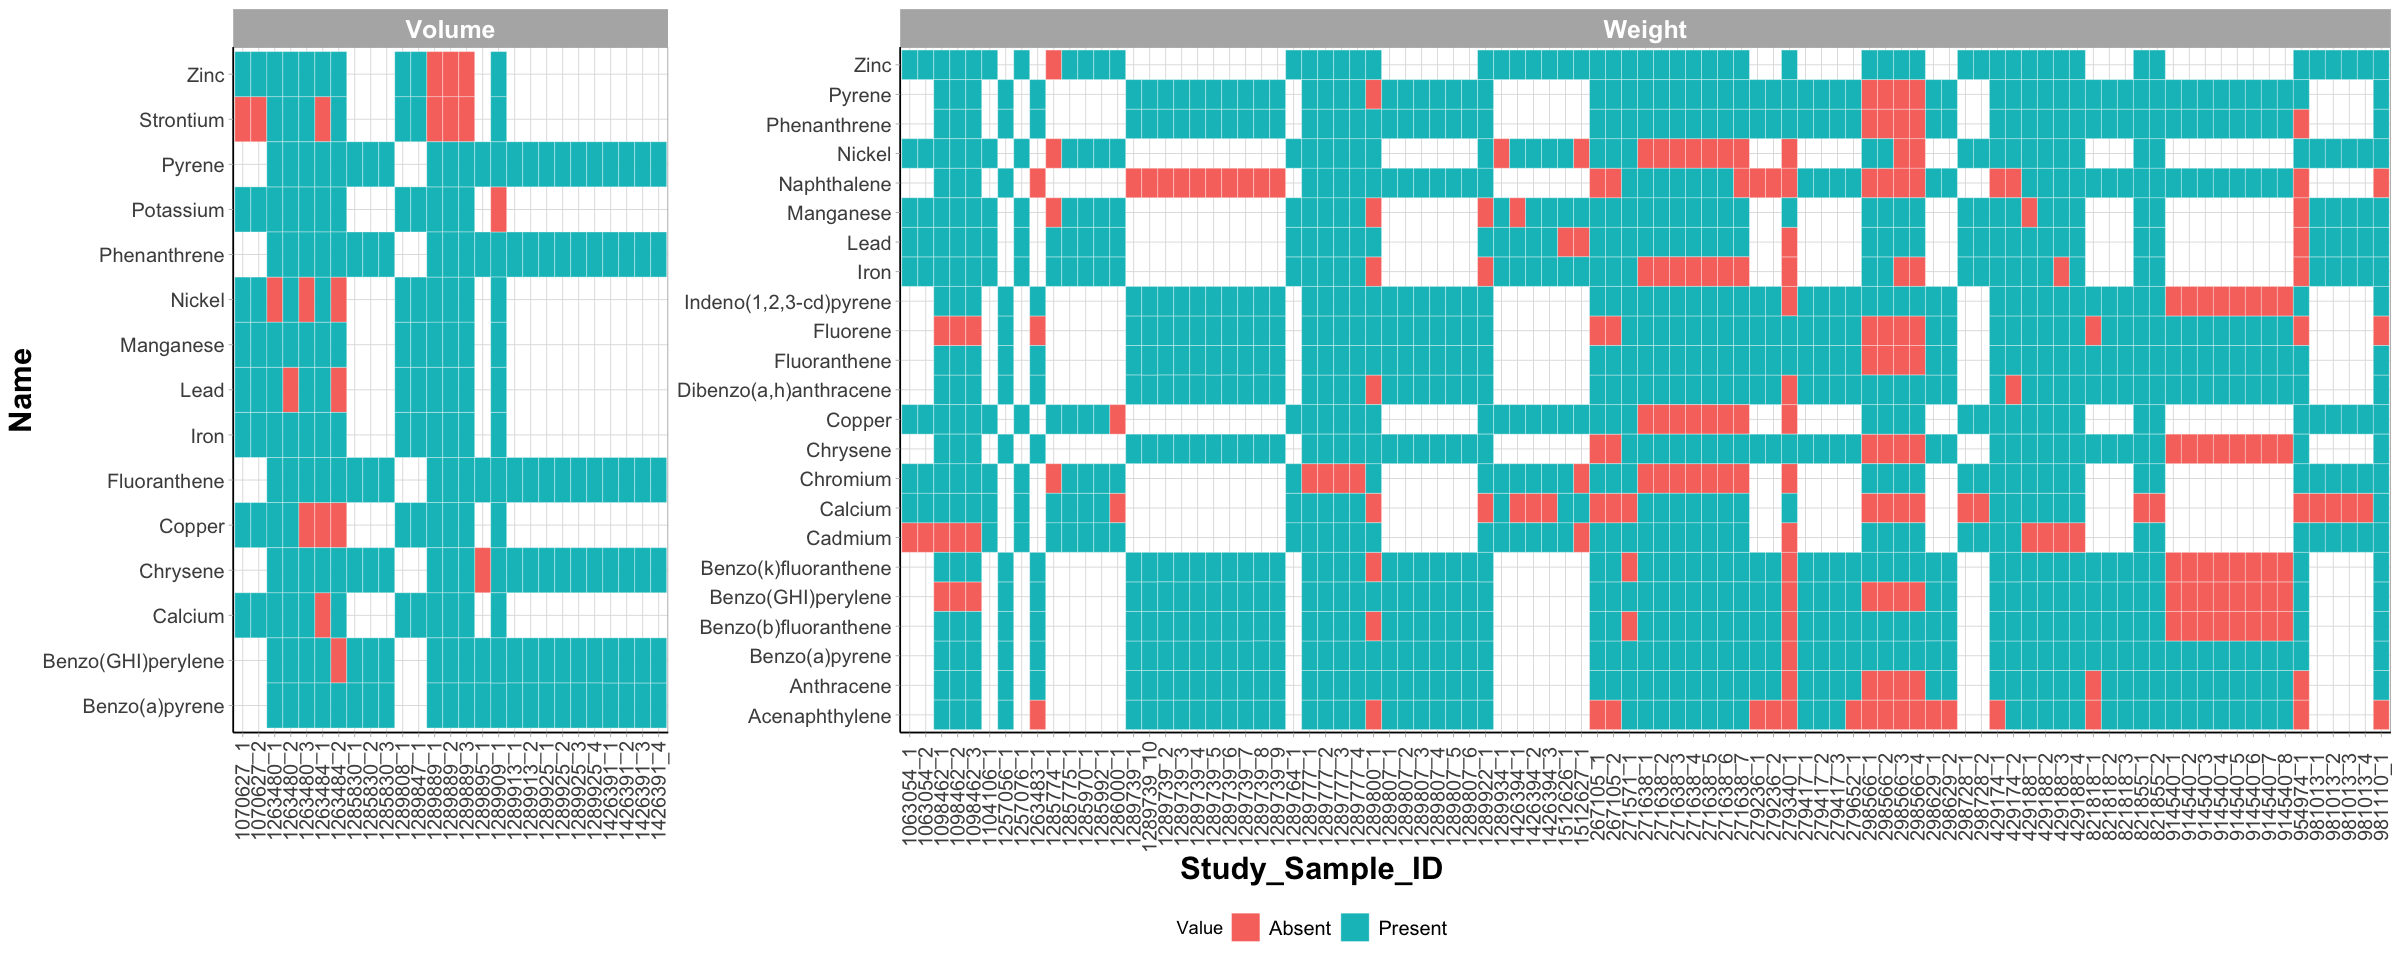

In [35]:
options(repr.plot.width=20, repr.plot.height=8) #changing size
ggplot(data = heat_map_df, aes(x = Study_Sample_ID, y = Name, fill = Value)) + 
  geom_tile(color = "white") + 

  ggh4x::facet_grid2(.~ Metric, scales = 'free', independent = "y", space = "free") + 

  theme_light() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = "bottom", #removing legend
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold"))  #changes size of facet y axis 